In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
torch.set_grad_enabled(True)

In [24]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5, 5))
        
        self.dense1 = nn.Linear(in_features=16*4*4, out_features=128)
        self.dense2 = nn.Linear(in_features=128, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=(2, 2), stride=2)
        
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=(2, 2), stride=2)
        
        t = t.reshape(-1, 16*4*4)
        
        t = F.relu(self.dense1(t))
        t = F.relu(self.dense2(t))
        t = self.out(t)
        
        return t

In [5]:
os.getcwd()

'C:\\Users\\An_asus\\Desktop\\Programming\\JupyterNotebook\\pytorch'

In [6]:
training_set = torchvision.datasets.FashionMNIST(
    root = 'C:\\Users\\An_asus\\Desktop\\Programming\\JupyterNotebook\\pytorch\\data\\Fashionmnist',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

C:\Users\An_asus\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [49]:
def accuracy(preds, labels):
    return torch.eq(torch.argmax(preds, dim=1), labels).sum().item()

In [50]:
cnn_model_0 = Network()

data_loader = torch.utils.data.DataLoader(training_set, batch_size=32)
optimizer = optim.Adam(cnn_model_0.parameters(), lr=0.01)

total_loss = 0
total_accuracy = 0

for batch in data_loader:
    images, labels = batch

    preds = cnn_model_0(images)
    loss = F.cross_entropy(preds, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    total_accuracy += accuracy(preds, labels)
    
print("epoch: ", 0, "total accuracy: ", total_accuracy, "total loss", total_loss)

epoch:  0 total accuracy:  47652 total loss 1031.069931462407


In [51]:
total_accuracy / len(training_set)

0.7942

In [52]:
def get_all_predictions(model, data_loader):
    all_preds = torch.tensor([])
    
    for batch in data_loader:
        images,labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

In [53]:
with torch.no_grad():
    predictions_loader = torch.utils.data.DataLoader(training_set, batch_size=32)
    training_preds = get_all_predictions(cnn_model_0, predictions_loader)

In [54]:
training_preds.grad

In [55]:
training_preds.grad_fn

In [56]:
print(training_preds.requires_grad)

False


In [57]:
def metric(preds, labels):
    predictions = accuracy(preds, labels)
    print(predictions)
    print(predictions/ len(training_set))

In [58]:
metric(training_preds, training_set.targets )

50557
0.8426166666666667


In [59]:
training_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [67]:
torch.argmax(training_preds, dim=1)

tensor([9, 0, 3,  ..., 3, 0, 5])

In [68]:
stacked = torch.stack((training_set.targets, torch.argmax(training_preds, dim=1)), dim=1)

In [72]:
stacked.shape

torch.Size([60000, 2])

In [74]:
cmt = torch.zeros(10, 10, dtype=torch.int32)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [75]:
for pair in stacked:
    true_label, predicted_label = pair
    cmt[true_label, predicted_label] = cmt[true_label, predicted_label] + 1

In [76]:
cmt

tensor([[5283,    4,  122,  321,   39,    7,  109,    1,  114,    0],
        [  43, 5736,   14,  165,    7,   11,   12,    0,   12,    0],
        [  94,    2, 4182,   66, 1320,    3,  279,    1,   53,    0],
        [ 182,   39,   26, 5314,  336,    4,   69,    0,   28,    2],
        [  11,    3,  364,  209, 5253,    3,  129,    1,   27,    0],
        [   4,    4,    0,   12,    0, 5628,    1,  251,   23,   77],
        [1690,    7,  790,  204, 1235,    6, 1926,    0,  142,    0],
        [   0,    0,    0,    0,    0,   69,    0, 5716,    5,  210],
        [  18,    1,   34,   15,   52,   49,   19,   16, 5793,    3],
        [   0,    3,    1,    9,    0,   50,    0,  207,    4, 5726]],
       dtype=torch.int32)

In [77]:
label_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker' ,'Bag ','Ankle boot']

In [78]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[5283,    4,  122,  321,   39,    7,  109,    1,  114,    0],
        [  43, 5736,   14,  165,    7,   11,   12,    0,   12,    0],
        [  94,    2, 4182,   66, 1320,    3,  279,    1,   53,    0],
        [ 182,   39,   26, 5314,  336,    4,   69,    0,   28,    2],
        [  11,    3,  364,  209, 5253,    3,  129,    1,   27,    0],
        [   4,    4,    0,   12,    0, 5628,    1,  251,   23,   77],
        [1690,    7,  790,  204, 1235,    6, 1926,    0,  142,    0],
        [   0,    0,    0,    0,    0,   69,    0, 5716,    5,  210],
        [  18,    1,   34,   15,   52,   49,   19,   16, 5793,    3],
        [   0,    3,    1,    9,    0,   50,    0,  207,    4, 5726]],
       dtype=torch.int32)


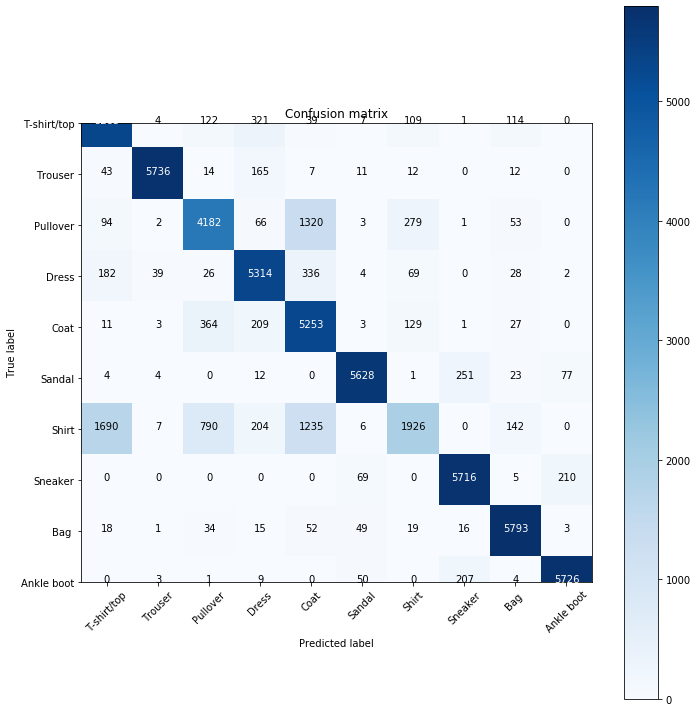

In [82]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cmt, label_names)

In [2]:
t1 = torch.tensor([3, -2, 5])
t2 = torch.tensor([-1, 0, 4])
t3 = torch.tensor([2, -5, 2])

In [3]:
torch.cat(
    (t1, t2, t3),
    dim= 0
)

tensor([ 3, -2,  5, -1,  0,  4,  2, -5,  2])

In [13]:
torch.stack((t1, t2, t3), dim=0)

tensor([[ 3, -2,  5],
        [-1,  0,  4],
        [ 2, -5,  2]])

In [18]:
torch.unsqueeze(torch.cat((t1, t2, t3), dim=0), dim=1)

tensor([[ 3],
        [-2],
        [ 5],
        [-1],
        [ 0],
        [ 4],
        [ 2],
        [-5],
        [ 2]])

In [22]:
torch.unsqueeze(torch.cat((t1, t2, t3), dim=0), dim=1).shape

torch.Size([9, 1])

In [23]:
from torchvision import models

In [24]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 '

In [25]:
alexnet = models.AlexNet()

In [26]:
resnet = models.resnet101(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\An_asus/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth


In [27]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
from torchvision import transforms

In [30]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

In [32]:
from PIL import Image

In [34]:
os.listdir("C:\\Users\\An_asus\\Desktop\\AI\\Test images")

['download.jpg', 'Madagascar_cats_1280x720.jpg']

In [35]:
img = Image.open("C:\\Users\\An_asus\\Desktop\\AI\\Test images\\Madagascar_cats_1280x720.jpg")

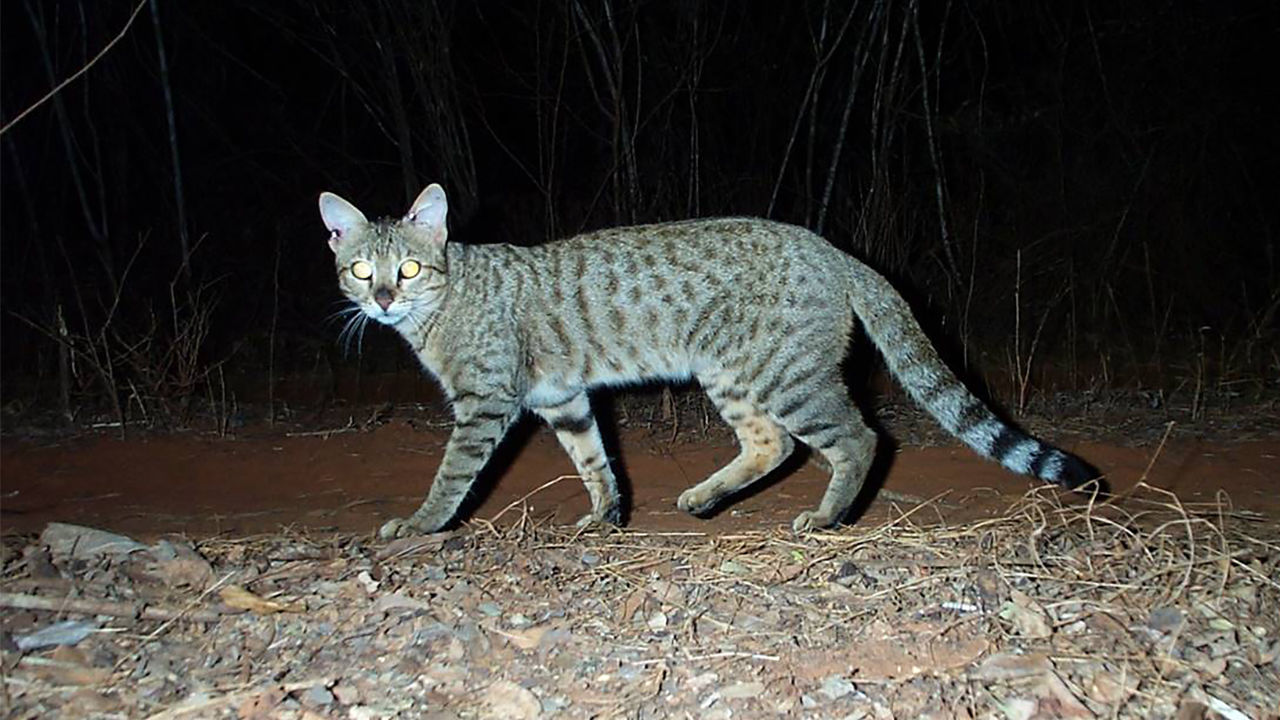

In [36]:
img

In [37]:
img.show

<bound method Image.show of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x1FD50A499C8>>

In [38]:
img_tensor = preprocess(img)

In [39]:
img_tensor.shape

torch.Size([3, 224, 224])

In [51]:
batch_tensor = torch.unsqueeze(img_tensor, dim=0)

In [49]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [52]:
output = resnet(batch_tensor)

C:\Users\An_asus\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [55]:
torch.argmax(output, dim=1)

tensor([285])

In [59]:
os.listdir("C:\\Users\\An_asus\\Desktop\\AI\\data sets\\imagenet labels\\imagenet labels")

['imagenet1000_clsidx_to_labels.txt']

In [60]:
with open("C:\\Users\\An_asus\\Desktop\\AI\\data sets\\imagenet labels\\imagenet labels\\imagenet1000_clsidx_to_labels.txt") as f:
    labels = [line.strip() for line in f.readlines()]

In [62]:
_, index = torch.max(output, dim=1)

In [73]:
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100

In [74]:
labels[index[0]], percentage[index[0]].item()

("285: 'Egyptian cat',", 79.0656967163086)

In [95]:
_, indices = torch.sort(output, descending=True)

In [96]:
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[("285: 'Egyptian cat',", 79.0656967163086),
 ("282: 'tiger cat',", 8.570685386657715),
 ("281: 'tabby, tabby cat',", 6.686949729919434),
 ("287: 'lynx, catamount',", 3.6279454231262207),
 ("276: 'hyena, hyaena',", 0.4696732759475708)]

In [98]:
os.listdir("C:\\Users\\An_asus\\Desktop\\AI\\Test images")

['download.jpg', 'Madagascar_cats_1280x720.jpg']

In [100]:
img_2 = Image.open("C:\\Users\\An_asus\\Desktop\\AI\\Test images\\download.jpg")

In [101]:
img_2_tensor = preprocess(img_2)

In [102]:
img_2_tensor.shape

torch.Size([3, 224, 224])

In [103]:
batch_tensor_2 = img_2_tensor.unsqueeze(dim= 0)

In [104]:
batch_tensor_2.shape

torch.Size([1, 3, 224, 224])

In [105]:
output_2 = resnet(batch_tensor_2)

In [107]:
_, index = torch.max(output_2, dim=1)

In [108]:
percentage_2 = torch.nn.functional.softmax(output_2, dim=1)[0] * 100
labels[index[0]], percentage_2[index[0]].item()

("378: 'capuchin, ringtail, Cebus capucinus',", 85.94766235351562)

In [110]:
_, indices = torch.sort(output_2, descending=True)
[(labels[idx], percentage_2[idx].item()) for idx in indices[0][:5]]

[("378: 'capuchin, ringtail, Cebus capucinus',", 85.94766235351562),
 ("380: 'titi, titi monkey',", 9.503677368164062),
 ("370: 'guenon, guenon monkey',", 1.5160937309265137),
 ("371: 'patas, hussar monkey, Erythrocebus patas',", 0.9307500123977661),
 ("382: 'squirrel monkey, Saimiri sciureus',", 0.6368669867515564)]

In [111]:
class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out
    

class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [112]:
netG = ResNetGenerator()

In [113]:
os.listdir("C:\\Users\\An_asus\\Desktop\\AI\\data sets\\horse2zebra")

['horse2zebra', 'horse2zebra.zip', 'horse2zebra_0.4.0.pth']

In [114]:
model_path = "C:\\Users\\An_asus\\Desktop\\AI\\data sets\\horse2zebra\\horse2zebra_0.4.0.pth"
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [115]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [116]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

In [117]:
os.listdir("C:\\Users\\An_asus\\Desktop\\AI\\Test images")

['download.jpg', 'Horse.jpg', 'Madagascar_cats_1280x720.jpg']

In [118]:
img = Image.open("C:\\Users\\An_asus\\Desktop\\AI\\Test images\\Horse.jpg")

In [119]:
img_tensor = preprocess(img)

In [121]:
batch_tensor = torch.unsqueeze(img_tensor, dim=0)

In [122]:
batch_tensor.shape

torch.Size([1, 3, 256, 384])

In [123]:
batch_out = netG(batch_tensor)

In [124]:
batch_out.shape

torch.Size([1, 3, 256, 384])

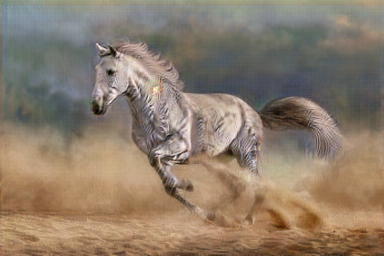

In [125]:
out_tensor = (batch_out.data.squeeze() + 1.0) / 2.0
out_image = transforms.ToPILImage()(out_tensor)
out_image.save("C:\\Users\\An_asus\\Desktop\\AI\\Test images\\Horse2Zebra.jpg")
out_image

In [130]:
os.listdir("C:\\Users\\An_asus\\Desktop\\AI\\Test images")

['download.jpg',
 'Horse.jpg',
 'Horse2.jpg',
 'Horse2Zebra.jpg',
 'Madagascar_cats_1280x720.jpg']

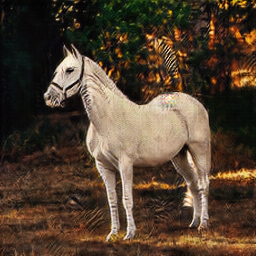

In [131]:
img = Image.open("C:\\Users\\An_asus\\Desktop\\AI\\Test images\\Horse2.jpg")
image_tensor = preprocess(img)
batch_tensor = torch.unsqueeze(image_tensor, dim=0)
batch_out = netG(batch_tensor)

out_tensor = (batch_out.data.squeeze() + 1.0) / 2.0
out_image = transforms.ToPILImage()(out_tensor)
out_image

In [126]:
python eval.py --model C:/Users/An_asus/Desktop/AI/data sets/ImageCaptioning/ImageCaptioning.pytorch-master/data/FC/fc-model.pth
    --infos_path C:/Users/An_asus/Desktop/AI/data sets/ImageCaptioning/ImageCaptioning.pytorch-master/data/FC/fc-infos.pkl
        --image_folder C:/Users/An_asus/Desktop/AI/Test images

SyntaxError: invalid syntax (<ipython-input-126-734dee9840d6>, line 1)

In [127]:
from torch import hub

resnet_18_model = hub.load('pytorch/vision:master',
                           'resnet18',
                           pretrained = True)

Downloading: "https://github.com/pytorch/vision/archive/master.zip" to C:\Users\An_asus/.cache\torch\hub\master.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\An_asus/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


In [132]:
resnet_18_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [148]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [162]:
img = Image.open("C:\\Users\\An_asus\\Desktop\\AI\\Test images\\Horse.jpg")
image_tensor = preprocess(img)
batch_tensor = torch.unsqueeze(image_tensor, dim=0)

out = resnet_18_model(batch_tensor)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
_, index = torch.max(out, dim=1)
labels[index[0]], percentage[index[0]].item()

("176: 'Saluki, gazelle hound',", 90.77333068847656)

In [165]:
x = torch.tensor([[23, -43],
              [24, 22],
              [0, -11]])

In [187]:
x[1:, 1]

tensor([ 22, -11])

In [188]:
weights = torch.randn(3)
image = torch.randn(3, 5, 5)

In [189]:
weights.shape

torch.Size([3])

In [190]:
weights

tensor([-0.1286, -0.4327,  0.5644])

In [191]:
image.shape

torch.Size([3, 5, 5])

In [192]:
image

tensor([[[ 1.0201,  0.6861,  0.7711, -0.3818,  0.9470],
         [ 0.8830, -0.0146, -0.5306, -1.1863,  0.5354],
         [-0.3329,  0.0759,  0.0934,  0.3784,  1.4182],
         [ 0.5485,  0.6599,  0.0997,  0.3056, -1.1535],
         [-0.5499, -0.5059, -0.8620,  0.8072,  1.6505]],

        [[ 1.0973, -0.5576, -1.4118,  0.4126, -0.2225],
         [ 0.9645, -0.2596, -1.4164, -1.7884, -1.9139],
         [ 0.4790,  0.0123, -0.1430,  0.0609,  0.9797],
         [-1.0288,  0.4759, -0.9504,  0.5543, -0.2870],
         [ 0.6617,  0.8029, -0.5580, -2.2733, -0.3239]],

        [[ 0.2406,  0.9938, -0.3197, -0.9257, -1.7658],
         [ 0.5157, -1.4356,  1.0072,  0.7241,  0.5192],
         [-0.8040,  2.3203,  1.5843, -0.0765,  0.6542],
         [ 0.4124, -1.3237, -0.7177, -0.8997,  1.1306],
         [-0.0652,  1.8883,  1.0436, -1.9666, -0.7236]]])

In [202]:
image_batch = torch.cat((image_batch, torch.randn(3, 5, 5).unsqueeze(dim=0)))

In [203]:
image_batch_gray = torch.mean(image_batch, dim=-3)

In [209]:
image_batch_gray.shape

torch.Size([2, 5, 5])

In [210]:
image_gray = torch.mean(image, dim=-3)

In [211]:
image_gray.shape

torch.Size([5, 5])

In [213]:
image_gray

tensor([[ 0.7860,  0.3741, -0.3201, -0.2983, -0.3471],
        [ 0.7877, -0.5699, -0.3132, -0.7502, -0.2864],
        [-0.2193,  0.8028,  0.5116,  0.1209,  1.0174],
        [-0.0226, -0.0626, -0.5228, -0.0133, -0.1033],
        [ 0.0155,  0.7284, -0.1255, -1.1443,  0.2010]])

In [215]:
weights.shape

torch.Size([3])

In [222]:
un_weights = weights.unsqueeze(-1).unsqueeze(-1)

In [223]:
image_weights = image*un_weights

In [226]:
image.shape, un_weights.shape

(torch.Size([3, 5, 5]), torch.Size([3, 1, 1]))

In [229]:
un_weights

tensor([[[-0.1286]],

        [[-0.4327]],

        [[ 0.5644]]])

In [228]:
un_weights * torch.ones(3, 5, 5)

tensor([[[-0.1286, -0.1286, -0.1286, -0.1286, -0.1286],
         [-0.1286, -0.1286, -0.1286, -0.1286, -0.1286],
         [-0.1286, -0.1286, -0.1286, -0.1286, -0.1286],
         [-0.1286, -0.1286, -0.1286, -0.1286, -0.1286],
         [-0.1286, -0.1286, -0.1286, -0.1286, -0.1286]],

        [[-0.4327, -0.4327, -0.4327, -0.4327, -0.4327],
         [-0.4327, -0.4327, -0.4327, -0.4327, -0.4327],
         [-0.4327, -0.4327, -0.4327, -0.4327, -0.4327],
         [-0.4327, -0.4327, -0.4327, -0.4327, -0.4327],
         [-0.4327, -0.4327, -0.4327, -0.4327, -0.4327]],

        [[ 0.5644,  0.5644,  0.5644,  0.5644,  0.5644],
         [ 0.5644,  0.5644,  0.5644,  0.5644,  0.5644],
         [ 0.5644,  0.5644,  0.5644,  0.5644,  0.5644],
         [ 0.5644,  0.5644,  0.5644,  0.5644,  0.5644],
         [ 0.5644,  0.5644,  0.5644,  0.5644,  0.5644]]])

In [224]:
image_weights

tensor([[[-0.1312, -0.0882, -0.0992,  0.0491, -0.1218],
         [-0.1136,  0.0019,  0.0682,  0.1526, -0.0689],
         [ 0.0428, -0.0098, -0.0120, -0.0487, -0.1824],
         [-0.0705, -0.0849, -0.0128, -0.0393,  0.1483],
         [ 0.0707,  0.0651,  0.1109, -0.1038, -0.2123]],

        [[-0.4748,  0.2413,  0.6109, -0.1785,  0.0963],
         [-0.4174,  0.1123,  0.6129,  0.7739,  0.8282],
         [-0.2073, -0.0053,  0.0619, -0.0264, -0.4239],
         [ 0.4452, -0.2059,  0.4112, -0.2399,  0.1242],
         [-0.2863, -0.3474,  0.2414,  0.9837,  0.1402]],

        [[ 0.1358,  0.5609, -0.1804, -0.5224, -0.9966],
         [ 0.2911, -0.8102,  0.5685,  0.4087,  0.2930],
         [-0.4538,  1.3095,  0.8942, -0.0432,  0.3692],
         [ 0.2328, -0.7471, -0.4051, -0.5078,  0.6381],
         [-0.0368,  1.0657,  0.5890, -1.1099, -0.4084]]])

In [230]:
batch_weights = image_batch * un_weights

In [240]:
lol = batch_weights.refine_names('batch', 'channels', 'height', 'width')

In [242]:
lol.shape, lol.names

(torch.Size([2, 3, 5, 5]), ('batch', 'channels', 'height', 'width'))

In [245]:
lol.names = None

In [246]:
lol.names

(None, None, None, None)

In [262]:
lol.storage()[1] = 6.534

In [264]:
id(lol)

2187496988904

In [267]:
lol

tensor([[[[ 6.5340e+00,  6.5340e+00, -9.9166e-02,  4.9097e-02, -1.2179e-01],
          [-1.1356e-01,  1.8767e-03,  6.8233e-02,  1.5256e-01, -6.8862e-02],
          [ 4.2812e-02, -9.7628e-03, -1.2014e-02, -4.8667e-02, -1.8240e-01],
          [-7.0542e-02, -8.4874e-02, -1.2817e-02, -3.9304e-02,  1.4835e-01],
          [ 7.0722e-02,  6.5066e-02,  1.1086e-01, -1.0381e-01, -2.1226e-01]],

         [[-4.7481e-01,  2.4126e-01,  6.1092e-01, -1.7853e-01,  9.6289e-02],
          [-4.1737e-01,  1.1233e-01,  6.1290e-01,  7.7386e-01,  8.2816e-01],
          [-2.0727e-01, -5.3101e-03,  6.1865e-02, -2.6360e-02, -4.2394e-01],
          [ 4.4519e-01, -2.0592e-01,  4.1124e-01, -2.3987e-01,  1.2421e-01],
          [-2.8633e-01, -3.4742e-01,  2.4145e-01,  9.8369e-01,  1.4017e-01]],

         [[ 1.3579e-01,  5.6087e-01, -1.8043e-01, -5.2244e-01, -9.9660e-01],
          [ 2.9106e-01, -8.1024e-01,  5.6847e-01,  4.0869e-01,  2.9304e-01],
          [-4.5376e-01,  1.3095e+00,  8.9417e-01, -4.3175e-02,  3.6922e-

In [293]:
t = torch.tensor([[3, 32, 1, 213, 11],
                  [5, 23, 1, 24, 102],
                  [0, 12, 4, 0, 1],
                  [22, 1, 3, -22, -234]])
t

tensor([[   3,   32,    1,  213,   11],
        [   5,   23,    1,   24,  102],
        [   0,   12,    4,    0,    1],
        [  22,    1,    3,  -22, -234]])

In [294]:
t_t = t.t()
t_t

tensor([[   3,    5,    0,   22],
        [  32,   23,   12,    1],
        [   1,    1,    4,    3],
        [ 213,   24,    0,  -22],
        [  11,  102,    1, -234]])

In [295]:
t.stride()

(5, 1)

In [296]:
t_t.stride()

(1, 5)

In [297]:
kk = torch.randn(2, 3, 4)

kk

tensor([[[ 0.4792,  0.3752, -0.3317, -1.4720],
         [ 0.7349,  0.2815,  0.4122, -0.2664],
         [-1.9023, -1.3610, -0.2505, -0.1342]],

        [[ 0.8776, -2.4142, -0.5001,  0.4470],
         [ 1.1034,  0.4087, -2.0557, -0.4179],
         [-1.5975,  0.2874,  0.8153,  0.9205]]])

In [299]:
kk.transpose(0, 2)

tensor([[[ 0.4792,  0.8776],
         [ 0.7349,  1.1034],
         [-1.9023, -1.5975]],

        [[ 0.3752, -2.4142],
         [ 0.2815,  0.4087],
         [-1.3610,  0.2874]],

        [[-0.3317, -0.5001],
         [ 0.4122, -2.0557],
         [-0.2505,  0.8153]],

        [[-1.4720,  0.4470],
         [-0.2664, -0.4179],
         [-0.1342,  0.9205]]])

In [303]:
kk.transpose(1, 2).shape

torch.Size([2, 4, 3])

In [304]:
kk.transpose(1, 2)

tensor([[[ 0.4792,  0.7349, -1.9023],
         [ 0.3752,  0.2815, -1.3610],
         [-0.3317,  0.4122, -0.2505],
         [-1.4720, -0.2664, -0.1342]],

        [[ 0.8776,  1.1034, -1.5975],
         [-2.4142,  0.4087,  0.2874],
         [-0.5001, -2.0557,  0.8153],
         [ 0.4470, -0.4179,  0.9205]]])